In [23]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (KFold,
    cross_val_score,
    GridSearchCV)
from sklearn.metrics import (mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    r2_score,
    accuracy_score)
from sklearn.impute import SimpleImputer
import scipy.stats as stats
import seaborn as sns

In [25]:
# Load data
exoplanets = pd.read_csv("exoplanets_clean.csv")

In [27]:
# Identify features
stellar_features = [
    'stellar_effective_temp_k',
    'stellar_radius_solar_radius',
    'stellar_mass_solar_mass',
    'stellar_metallicity_dex',
    'stellar_luminosity_log_solar',
    'stellar_surface_gravity_log10_cms2',
    'stellar_age_gyr',
    'stellar_density_gcm3',
    'stellar_rotational_velocity_kms',
    'stellar_rotational_period_days',
    'systemic_radial_velocity_kms']

# Identify targets
planetary_targets = [
    'planet_mass_earth_mass',
    'planet_radius_earth_radius',
    'orbital_period_days',
    'orbit_semi_major_axis_au',
    'planet_density_gcm3']

In [29]:
print(exoplanets[stellar_features].isna().mean()) # Check for the percentage of NAs in each column. 

stellar_effective_temp_k              0.042156
stellar_radius_solar_radius           0.045957
stellar_mass_solar_mass               0.001209
stellar_metallicity_dex               0.082757
stellar_luminosity_log_solar          0.044921
stellar_surface_gravity_log10_cms2    0.046994
stellar_age_gyr                       0.207844
stellar_density_gcm3                  0.090705
stellar_rotational_velocity_kms       0.644091
stellar_rotational_period_days        0.875777
systemic_radial_velocity_kms          0.606945
dtype: float64


In [31]:
stellar_features = [
    'stellar_effective_temp_k',
    'stellar_radius_solar_radius',
    'stellar_mass_solar_mass',
    'stellar_metallicity_dex',
    'stellar_luminosity_log_solar',
    'stellar_surface_gravity_log10_cms2',
    'stellar_age_gyr',
    'stellar_density_gcm3',
    'stellar_rotational_velocity_kms',
    'stellar_rotational_period_days',
    'systemic_radial_velocity_kms']

planetary_targets = [
    'planet_mass_earth_mass',
    'planet_radius_earth_radius',
    'orbital_period_days',
    'orbit_semi_major_axis_au',
    'planet_density_gcm3']


Target: planet_mass_earth_mass
Average R² score: 0.2774
R² scores per fold: [0.1735 0.4809 0.3031 0.3501 0.3418 0.3326 0.0386 0.2771 0.2203 0.2557]


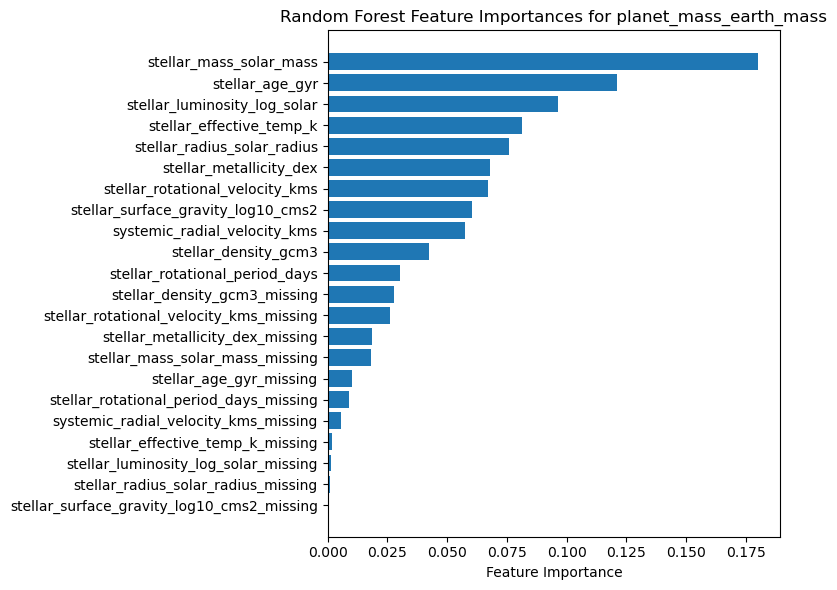


Target: planet_radius_earth_radius
Average R² score: 0.5779
R² scores per fold: [0.5627 0.5121 0.5582 0.6662 0.592  0.6263 0.5385 0.5393 0.5382 0.6459]


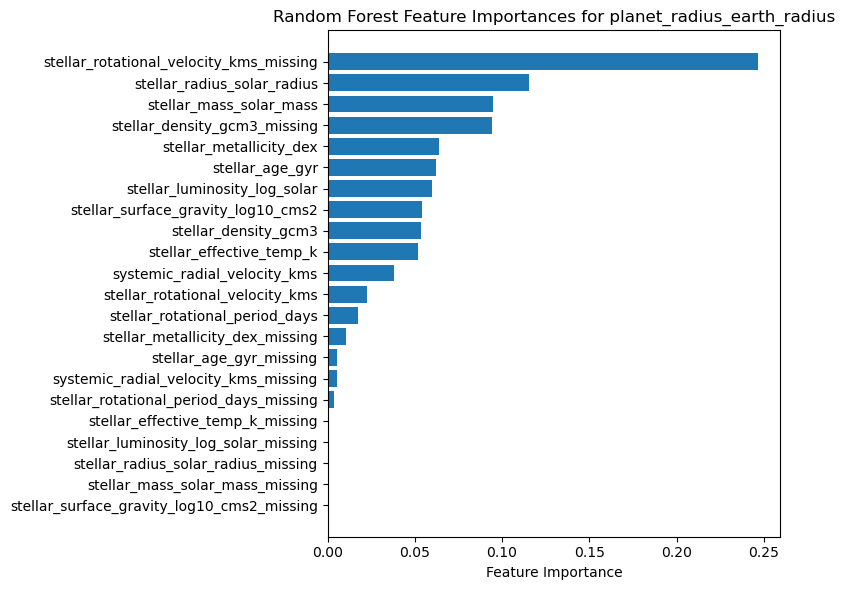


Target: orbital_period_days
Average R² score: -2870835.1436
R² scores per fold: [ 4.23800000e-01 -1.60000000e-03 -3.47066000e+01 -3.24000000e-01
  3.09600000e-01 -5.80691470e+03 -3.89600000e-01 -6.91765000e+01
 -2.87010586e+07 -1.38201330e+03]


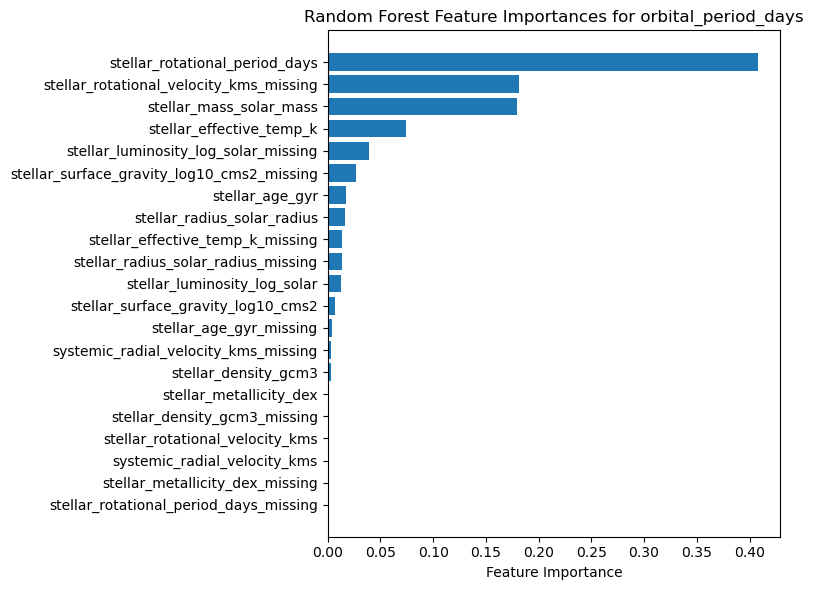


Target: orbit_semi_major_axis_au
Average R² score: -3.3638
R² scores per fold: [-1.95100e-01 -4.55100e-01 -9.00930e+00  3.10000e-03  2.09000e-02
 -1.98536e+01 -1.23610e+00 -2.07840e+00 -8.11900e-01 -2.23000e-02]


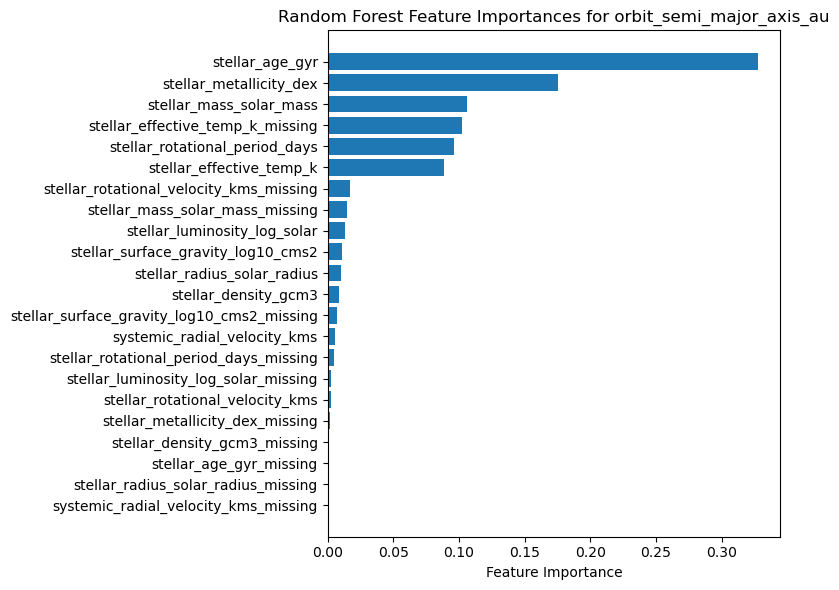


Target: planet_density_gcm3
Average R² score: -1.6864
R² scores per fold: [-2.4733e+00 -1.2391e+00 -5.0000e-04 -1.1388e+00  1.0000e-04 -8.4000e-01
 -2.6237e+00 -3.9351e+00 -1.7499e+00 -2.8639e+00]


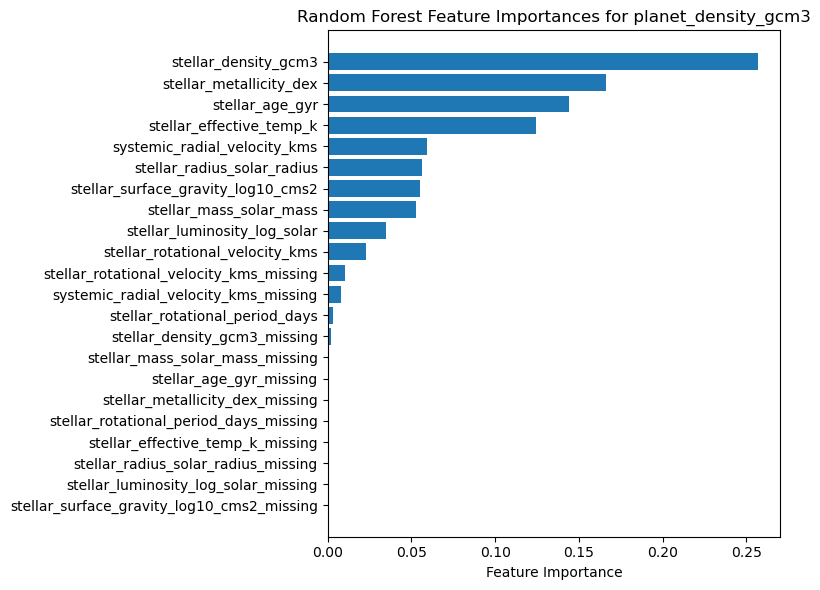

In [35]:
## Random Tree on everything, filling missing with median:

# Below is the same code which can be found in the Linear Regression code, with some changes which
# are commented here. 
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for target in planetary_targets:
    df = exoplanets[stellar_features + [target]].copy()
    df = df.dropna(subset=[target]) 
    
    X = df[stellar_features].values
    y = df[target].values 

    model = RandomForestRegressor(n_estimators=100, random_state=42)

    r2_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Here we deal with the NAs. We fill NAs with the median value. However, we do not want to generate noise. 
        # So we also add a column of binary indicators on whether this column was NA or not. 
        # Additionally, we input only on train data so we avoid data leakage. It is then applied to 
        # test data seperately.
        imputer = SimpleImputer(strategy='median', add_indicator=True)
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        model.fit(X_train_imputed, y_train)
        preds = model.predict(X_test_imputed)
        r2_scores.append(r2_score(y_test, preds))

    print(f"\nTarget: {target}")
    print(f"Average R² score: {np.mean(r2_scores):.4f}")
    print(f"R² scores per fold: {np.round(r2_scores, 4)}")

    # Fit model on full data for feature importance. Code adapted from:
    # https://stackoverflow.com/questions/39204724/feature-importances-in-scikit-learn-how-choose-correct-parameters
    imputer_full = SimpleImputer(strategy='median', add_indicator=True)
    X_imputed_full = imputer_full.fit_transform(X)
    model.fit(X_imputed_full, y)
    importances = model.feature_importances_
    indicator_features = imputer_full.indicator_.features_ # Get indices for the indicator columns
    indicator_names = [f"{stellar_features[idx]}_missing" for idx in indicator_features] # Name
    # these columns with the column name _ missing
    all_feature_names = stellar_features + indicator_names # Combine all features
    # Above takes care of an index error I was recieving due to the indicator column
    # Below plots the feature importance just to see if the missing values have importance. adapted from https://stackoverflow.com/questions/62536918/plot-feature-importance-with-top-10-features-using-matplotlib
    ### This cannot be used for further analysis since we did not deal with collinearity !!!!!!!!!!
    sorted_idx = np.argsort(importances) # Sort in ascending order
    plt.barh(range(len(importances)), importances[sorted_idx], align='center') # Reorder bars in the sorted order
    plt.yticks(range(len(importances)), [all_feature_names[i] for i in sorted_idx]) # Use all feature
    # names for the plot
    plt.xlabel("Feature Importance")
    plt.title(f"Random Forest Feature Importances for {target}")
    plt.tight_layout()
    plt.show()

In [33]:
# The only option seems to be to remove rotational velocity and density. 
# This is likely something harder to measure for smaller planets, so
# the model is finding that the data being missing is relevant to predicting the planet
# radius. Technically that is correct for this data, but that does not get us any closer to
# generalizing the model. 

# Identify features
stellar_features = [
    'stellar_effective_temp_k',
    'stellar_radius_solar_radius',
    'stellar_mass_solar_mass',
    'stellar_metallicity_dex',
    'stellar_luminosity_log_solar',
    'stellar_surface_gravity_log10_cms2',
    'stellar_age_gyr',
    'stellar_rotational_period_days',
    'systemic_radial_velocity_kms']

# Adjust target to only include planet radius
planetary_targets = ['planet_radius_earth_radius']


Target: planet_radius_earth_radius
Average R-squared: 0.4795
Average MAE: 2.5046
Average RMSE: 3.8291
Average Median AE: 1.3760


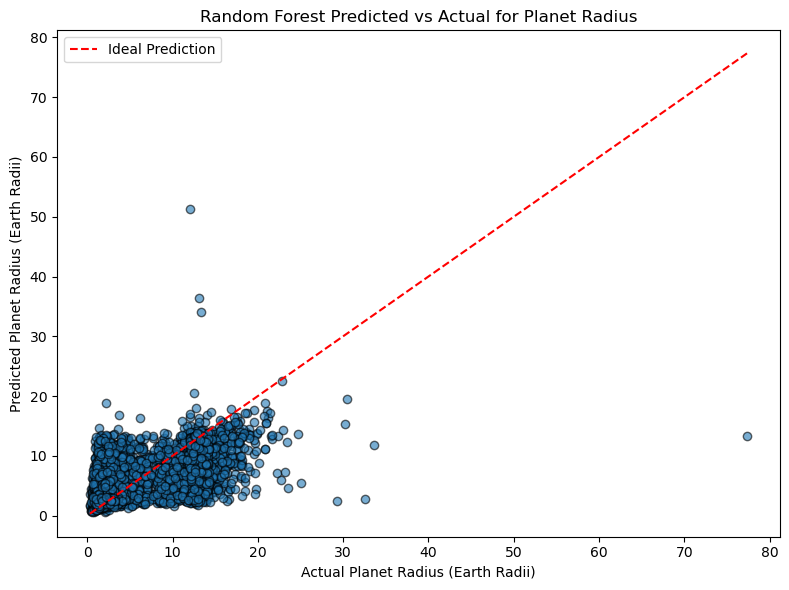

In [35]:
## Random Tree on planet radius only with default parameters and accuracy metrics :
# Below I use the code with simply replacing NAs with the median. As we can see from above, none of
# the other missing values held strong feature importance.

# K-Fold setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for target in planetary_targets:
    df = exoplanets[stellar_features + [target]].copy()
    df = df.dropna(subset=[target])

    X = df[stellar_features].values
    y = df[target].values

    model = RandomForestRegressor(n_estimators=100, random_state=42)

    r2_scores = []
    mae_scores = []
    rmse_scores = []
    medae_scores = []
    predicts = []
    actuals = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        imputer = SimpleImputer(strategy='median')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        model.fit(X_train_imputed, y_train)
        preds = model.predict(X_test_imputed)
        y_true = y_test
        
        preds = model.predict(X_test_imputed)
        predicts.extend(preds)
        actuals.extend(y_test)

        r2_scores.append(r2_score(y_true, preds))
        mae_scores.append(mean_absolute_error(y_true, preds))
        rmse_scores.append(np.sqrt(mean_squared_error(y_true, preds)))
        medae_scores.append(median_absolute_error(y_true, preds))

    print(f"\nTarget: {target}")
    print(f"Average R-squared: {np.mean(r2_scores):.4f}")
    print(f"Average MAE: {np.mean(mae_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"Average Median AE: {np.mean(medae_scores):.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(actuals, predicts, alpha=0.6, edgecolors='k')
    plt.plot([min(actuals), max(actuals)],
         [min(actuals), max(actuals)],
         color='red', linestyle='--', label='Ideal Prediction')
    plt.xlabel('Actual Planet Radius (Earth Radii)')
    plt.ylabel('Predicted Planet Radius (Earth Radii)')
    plt.title('Random Forest Predicted vs Actual for Planet Radius')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [36]:
# To gauge overfitting, we want to calculate the MSE of the testing data
# https://www.statology.org/overfitting-machine-learning/
# To compare this number, we also calculate the training MSE. If testing is much
# higher than training, we know the model is overfitted. 

train_pred = model.predict(X_train_imputed) # Use the model from above to make predictions on the 
# training data set from the last fold 
test_pred = model.predict(X_test_imputed) # Use the model from above to make predictions on the 
# testing data set from the last fold 

train_mse = mean_squared_error(y_train, train_pred) # Calculate MSE for training data
test_mse = mean_squared_error(y_test, test_pred) # Calculate MSE for test data

print(f"Train MSE: {train_mse:.3f}") # Print results
print(f"Test MSE: {test_mse:.3f}") # Print results

Train MSE: 2.777
Test MSE: 11.110



Target: planet_radius_earth_radius
Average R-squared: 0.4694
Average MAE: 2.6724
Average RMSE: 3.8683
Average Median AE: 1.6621


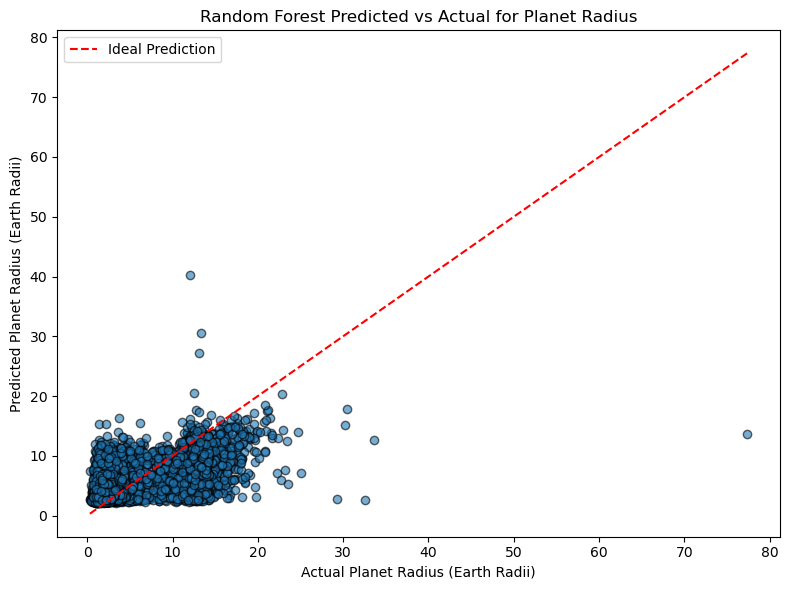

In [37]:
## Random Tree on planet radius only with hyperparameters :

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for target in planetary_targets:
    df = exoplanets[stellar_features + [target]].copy()
    df = df.dropna(subset=[target])

    X = df[stellar_features].values
    y = df[target].values

    model = RandomForestRegressor(
        n_estimators=800,
        max_depth=10,
        min_samples_split=10,
        random_state=42)

    predicts = []
    actuals = []
    r2_scores = []
    mae_scores = []
    rmse_scores = []
    medae_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        imputer = SimpleImputer(strategy='median')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        model.fit(X_train_imputed, y_train)

        
        preds = model.predict(X_test_imputed)
        predicts.extend(preds)
        actuals.extend(y_test)

        
        r2_scores.append(r2_score(y_test, preds))
        mae_scores.append(mean_absolute_error(y_test, preds))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))
        medae_scores.append(median_absolute_error(y_test, preds))

    print(f"\nTarget: {target}")
    print(f"Average R-squared: {np.mean(r2_scores):.4f}")
    print(f"Average MAE: {np.mean(mae_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"Average Median AE: {np.mean(medae_scores):.4f}")


    plt.figure(figsize=(8, 6))
    plt.scatter(actuals, predicts, alpha=0.6, edgecolors='k')
    plt.plot([min(actuals), max(actuals)],
         [min(actuals), max(actuals)],
         color='red', linestyle='--', label='Ideal Prediction')
    plt.xlabel('Actual Planet Radius (Earth Radii)')
    plt.ylabel('Predicted Planet Radius (Earth Radii)')
    plt.title('Random Forest Predicted vs Actual for Planet Radius')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [38]:
train_pred = model.predict(X_train_imputed)
test_pred = model.predict(X_test_imputed)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")

Train MSE: 9.309
Test MSE: 11.479


In [344]:
# Code adapted from: https://medium.com/cloudvillains/random-forest-with-grid-search-b739fb0da311

param_grid = {
    "n_estimators": [300, 400, 500, 800],
    "max_depth": [None, 5],
    "min_samples_split": [2, 5, 10]}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1)

grid_search.fit(X, y)
print("Best params:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

Best params: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 800}
Best R2 score: 0.300847267673433


In [42]:
## Random Forest on planet radius, with log transformation of target :

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for target in planetary_targets:
    df = exoplanets[stellar_features + [target]].copy()
    df = df.dropna(subset=[target])

    X = df[stellar_features].values

    # Log transform target (radius) 
    y_og = df[target].values
    y = np.log1p(y_og)

    model = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_split=5,
        random_state=42)

    r2_scores = []
    mae_scores = []
    rmse_scores = []
    medae_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test_log = y[train_idx], y[test_idx]
        y_test_og = y_og[test_idx]

        imputer = SimpleImputer(strategy='median')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        model.fit(X_train_imputed, y_train)
        preds_log = model.predict(X_test_imputed)

        # Reverse log transformation on predictions and original data
        preds = np.expm1(preds_log)
        y_true = y_test_og

        # Compute metrics, making sure they are applied on the same scale (original)
        r2_scores.append(r2_score(y_true, preds))
        mae_scores.append(mean_absolute_error(y_true, preds))
        rmse_scores.append(np.sqrt(mean_squared_error(y_true, preds)))
        medae_scores.append(median_absolute_error(y_true, preds))

    print(f"\nTarget: {target}")
    print(f"Average R-squared: {np.mean(r2_scores):.4f}")
    print(f"Average MAE: {np.mean(mae_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"Average Median AE: {np.mean(medae_scores):.4f}")


Target: planet_radius_earth_radius
Average R-squared: 0.4327
Average MAE: 2.5282
Average RMSE: 4.0028
Average Median AE: 1.1492


In [43]:
train_pred = model.predict(X_train_imputed)
test_pred = model.predict(X_test_imputed)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")

Train MSE: 0.069
Test MSE: 38.227


In [44]:
# Switch targets
planetary_targets = ['planet_mass_earth_mass']

In [45]:
## Random forest for planet mass with hyperparameters: 

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for target in planetary_targets:
    df = exoplanets[stellar_features + [target]].copy()
    df = df.dropna(subset=[target])

    X = df[stellar_features].to_numpy()
    y = df[target].to_numpy()

    model = RandomForestRegressor(
        n_estimators=400,
        max_depth=10, 
        min_samples_split=20,
        random_state=42)

    r2_scores = []
    mae_scores = []
    rmse_scores = []
    medae_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        imputer = SimpleImputer(strategy='median')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        model.fit(X_train_imputed, y_train)
        preds = model.predict(X_test_imputed)

        r2_scores.append(r2_score(y_test, preds))
        mae_scores.append(mean_absolute_error(y_test, preds))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))
        medae_scores.append(median_absolute_error(y_test, preds))

    print(f"\nTarget: {target}")
    print(f"Average R-squared: {np.mean(r2_scores):.4f}")
    print(f"Average MAE: {np.mean(mae_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"Average Median AE: {np.mean(medae_scores):.4f}")


Target: planet_mass_earth_mass
Average R-squared: 0.2738
Average MAE: 406.0631
Average RMSE: 919.2708
Average Median AE: 147.9017


In [349]:
param_grid = {
    "n_estimators": [300, 400, 500],
    "max_depth": [None, 5],
    "min_samples_split": [2, 5, 10, 15, 20]}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1)

grid_search.fit(X, y)
print("Best params:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

Best params: {'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 400}
Best R2 score: 0.2563407346525731


In [46]:
train_pred = model.predict(X_train_imputed)
test_pred = model.predict(X_test_imputed)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")

Train MSE: 663246.302
Test MSE: 579037.091


In [47]:
# Identify features
stellar_features = [
    'stellar_effective_temp_k',
    'stellar_radius_solar_radius',
    'stellar_mass_solar_mass',
    'stellar_metallicity_dex',
    'stellar_luminosity_log_solar',
    'stellar_surface_gravity_log10_cms2',
    'stellar_age_gyr',
    'stellar_density_gcm3',
    'stellar_rotational_period_days',
    'systemic_radial_velocity_kms',
    'is_circumbinary']

# Identify targets
planetary_targets = ['planet_density_gcm3']


Target: planet_density_gcm3
Average R-squared: -1.1947
Average MAE: 3.7498
Average RMSE: 21.4008
Average Median AE: 1.7877


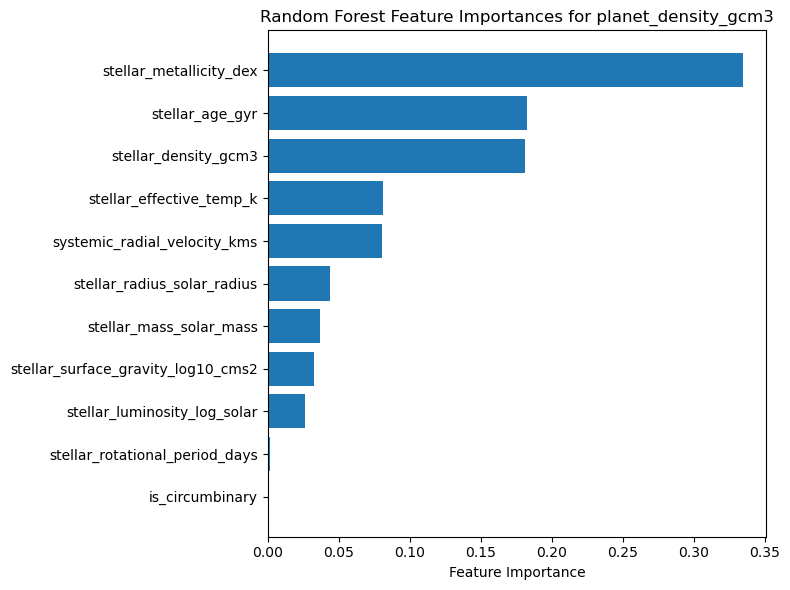

In [48]:
## Random Tree on planet density only with hyperparameters :

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for target in planetary_targets:
    df = exoplanets[stellar_features + [target]].copy()
    df = df.dropna(subset=[target])

    X = df[stellar_features].values
    y = df[target].values

    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=5,
        min_samples_split=10,
        random_state=42)

    r2_scores = []
    mae_scores = []
    rmse_scores = []
    medae_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        imputer = SimpleImputer(strategy='median')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        model.fit(X_train_imputed, y_train)
        preds = model.predict(X_test_imputed)

        r2_scores.append(r2_score(y_test, preds))
        mae_scores.append(mean_absolute_error(y_test, preds))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))
        medae_scores.append(median_absolute_error(y_test, preds))

    print(f"\nTarget: {target}")
    print(f"Average R-squared: {np.mean(r2_scores):.4f}")
    print(f"Average MAE: {np.mean(mae_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"Average Median AE: {np.mean(medae_scores):.4f}")

    model.fit(X, y)
    importances = model.feature_importances_
    feature_names = stellar_features

    sorted_idx = np.argsort(importances)
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(importances)), importances[sorted_idx], align='center')
    plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title(f"Random Forest Feature Importances for {target}")
    plt.tight_layout()
    plt.show()

In [ ]:
param_grid = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [None, 5],
    "min_samples_split": [2, 5, 10]}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1)

grid_search.fit(X, y)
print("Best params:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

In [49]:
train_pred = model.predict(X_train_imputed)
test_pred = model.predict(X_test_imputed)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")

Train MSE: 597.392
Test MSE: 38.581


In [50]:
exoplanets_derived = exoplanets.copy()

exoplanets_derived['mass_density_ratio'] = (
    exoplanets['stellar_mass_solar_mass'] / exoplanets['stellar_density_gcm3'])

# Keep only the one which was useful previously. 
derived_features = ['mass_density_ratio']

# Identify features
stellar_features = [
    'stellar_effective_temp_k',
    'stellar_radius_solar_radius',
    'stellar_mass_solar_mass',
    'stellar_metallicity_dex',
    'stellar_luminosity_log_solar',
    'stellar_surface_gravity_log10_cms2',
    'stellar_age_gyr',
    'stellar_rotational_period_days',
    'systemic_radial_velocity_kms']

# Identify targets
planetary_targets = [
    'planet_radius_earth_radius']

# Combine features
all_features = stellar_features + derived_features


Target: planet_radius_earth_radius
Average R-squared: 0.4721
Average MAE: 2.7039
Average RMSE: 3.8591
Average Median AE: 1.7607


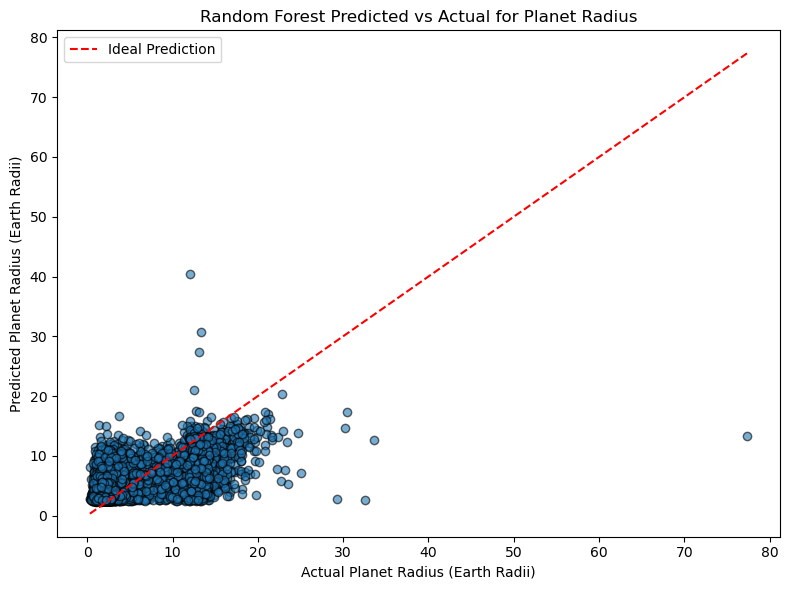

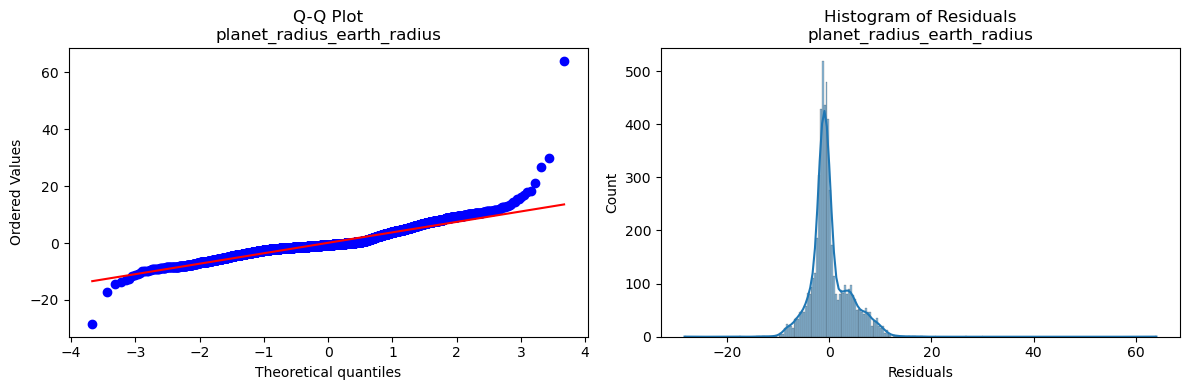

In [51]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for target in planetary_targets:
    df = exoplanets_derived[all_features + [target]].copy()
    df = df.dropna(subset=[target])

    X = df[all_features].values
    y = df[target].values

    model = RandomForestRegressor(
        n_estimators=800,
        max_depth=9,
        min_samples_split=10,
        random_state=42)

    predicts = []
    actuals = []
    r2_scores = []
    mae_scores = []
    rmse_scores = []
    medae_scores = []
    residuals = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        imputer = SimpleImputer(strategy='median')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        model.fit(X_train_imputed, y_train)
        preds = model.predict(X_test_imputed)
        predicts.extend(preds)
        actuals.extend(y_test)

        r2_scores.append(r2_score(y_test, preds))
        mae_scores.append(mean_absolute_error(y_test, preds))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))
        medae_scores.append(median_absolute_error(y_test, preds))
        residuals.extend(y_test - preds)            

    print(f"\nTarget: {target}")
    print(f"Average R-squared: {np.mean(r2_scores):.4f}")
    print(f"Average MAE: {np.mean(mae_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"Average Median AE: {np.mean(medae_scores):.4f}")


    plt.figure(figsize=(8, 6))
    plt.scatter(actuals, predicts, alpha=0.6, edgecolors='k')
    plt.plot([min(actuals), max(actuals)],
         [min(actuals), max(actuals)],
         color='red', linestyle='--', label='Ideal Prediction')
    plt.xlabel('Actual Planet Radius (Earth Radii)')
    plt.ylabel('Predicted Planet Radius (Earth Radii)')
    plt.title('Random Forest Predicted vs Actual for Planet Radius')
    plt.legend()
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    stats.probplot(residuals, dist="norm", plot=axs[0]) # Plot a probplot QQ since our quantities are different scales
    # https://stats.stackexchange.com/questions/585566/what-are-the-main-difference-between-a-qq-plot-and-a-probability-plot-for-measur
    axs[0].set_title(f"Q-Q Plot\n{target}") # Label each graph with the target

    sns.histplot(residuals, kde=True, ax=axs[1]) # Plot a histogram of the residuals with a kde curve overlaid https://python-graph-gallery.com/20-basic-histogram-seaborn/
    axs[1].set_title(f"Histogram of Residuals\n{target}") # Label each graph with the target
    axs[1].set_xlabel("Residuals")

    plt.tight_layout()
    plt.show()

In [52]:
train_pred = model.predict(X_train_imputed)
test_pred = model.predict(X_test_imputed)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")

Train MSE: 10.051
Test MSE: 11.410
